# Spam classifer with Natural Language processing and Naive Bayes

## Libaries importing

In [361]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, average_precision_score, precision_recall_curve, plot_precision_recall_curve
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from typing import Dict, List
from io import BytesIO
import requests
import tarfile
import glob
import re

## Importing datasets

In [2]:
spam_ham_sms = pd.read_csv("datasets/sms(ham-spam).csv").drop("Unnamed: 0", axis=1)
spam_ham_sms.sample(3)

,labels,messages
1071,ham,"alright, I'll make sure the car is back tonight"
653,ham,"Wait, do you know if wesleys in town? I bet sh..."
2229,ham,Those were my exact intentions


In [24]:
def extract_spam_data():
    Base_url = "https://spamassassin.apache.org/old/publiccorpus"

    files = ["20021010_easy_ham.tar.bz2",
             "20021010_hard_ham.tar.bz2",            
             "20021010_spam.tar.bz2"]

    Output_dir = "datasets/emailSpam"

    for filename in files:
        content = requests.get(f"{Base_url}/{filename}").content
        fin = BytesIO(content)

        with tarfile.open(fileobj=fin, mode='r:bz2') as tf:
            tf.extractall(Output_dir)

    return files

In [25]:
files = extract_spam_data()

In [3]:
path = "datasets\emailSpam\*\*"

full_data:List[Dict] = []

for filename in glob.glob(path):
    spamOrham = "spam" in filename
    if spamOrham:
        with open(filename, errors='ignore') as files:
            for line in files:
                if line.startswith("Subject:"):
                    subject = line.lstrip("Subject: ")
                    data = {"labels": "spam", "messages": subject}
                    full_data.append(data)

In [4]:
spam_ham_email = pd.DataFrame(data = full_data, columns=['labels', 'messages'])
spam_ham_email.sample(3)

,labels,messages
352,spam,fwd: NORTON SYSTEMWORKS CLEARANCE SALE_ONLY $...
437,spam,Guaranteed Best Mortgage Rate\n
376,spam,"Last time you spent $25 did u make $100,000,s?..."


In [160]:
data = pd.concat([spam_ham_email, spam_ham_sms])

### Visualising data -> Balance or not

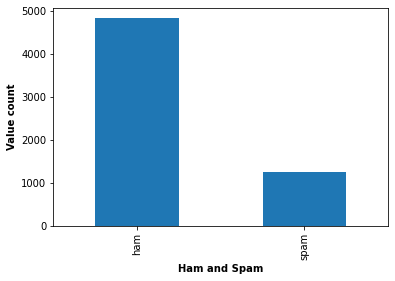

In [161]:
pd.value_counts(data['labels']).plot.bar()
plt.ylabel("Value count", weight='bold')
plt.xlabel("Ham and Spam", weight='bold')
plt.show()

## Using nltk for Lemmatization and Stemming

In [162]:
wordnet = WordNetLemmatizer()

In [244]:
for i in range(len(spam_ham_sms['messages'])):
    capture_words = re.sub('[^a-zA-Z]', ' ', spam_ham_sms['messages'].iloc[i])
    lowering_spliting = capture_words.lower().split()
    remove_word = [wordnet.lemmatize(word) for word in lowering_spliting
             if not word in set(stopwords.words('english'))]

    finalising = ' '.join(remove_word)
    spam_ham_sms['messages'].iloc[i] = finalising

In [246]:
data = pd.get_dummies(spam_ham_sms, columns=['labels'], drop_first=True)
data.head(3)

,messages,labels_spam
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry wkly comp win fa cup final tkts st ...,1


In [251]:
data_x = np.array(data['messages'])
data_y = np.array(data['labels_spam'])

### Using Countvectorizer

In [340]:
count_vectorizer = CountVectorizer()
x = count_vectorizer.fit_transform(data_x)

In [341]:
x_train, x_test, y_train, y_test = train_test_split(x, data_y,test_size=0.2, random_state=0)

In [342]:
naive_bayes_classifer = MultinomialNB()
naive_bayes_classifer.fit(x_train, y_train)

MultinomialNB()

In [343]:
y_pred = naive_bayes_classifer.predict(x_test)

0.9766816143497757


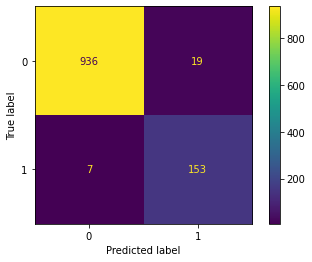

In [344]:
plot_confusion_matrix(naive_bayes_classifer, x_test, y_test)
print(accuracy_score(y_test, y_pred))

### Using Count Vectorizer with para=max_feature

In [379]:
count_vectorizer2 = CountVectorizer(max_features = 5000)

In [380]:
x2 = count_vectorizer2.fit_transform(data_x)

In [381]:
x_train2, x_test_2, y_train2, y_test_2 = train_test_split(x2, data_y, test_size=0.2, random_state=0)

In [382]:
naive_bayes_classifer_2 = MultinomialNB()
naive_bayes_classifer_2.fit(x_train2, y_train2)
y_pred2 = naive_bayes_classifer_2.predict(x_test2)

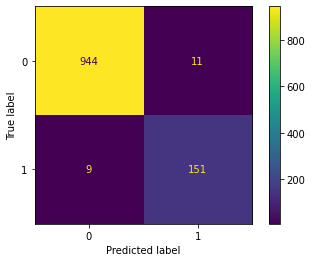

In [383]:
plot_confusion_matrix(naive_bayes_classifer_2, x_test2, y_test2)

In [384]:
accuracy_score(y_test2, y_pred2)

0.9820627802690582

### Using Tfidf

In [352]:
cv = TfidfVectorizer()
x3 = cv.fit_transform(data_x)

In [353]:
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x3, data_y, test_size=0.2, random_state=0)

In [356]:
naive_bayes_classifer_3 = MultinomialNB()
naive_bayes_classifer_3.fit(x_train_3, y_train_3)

MultinomialNB()

In [357]:
y_pred3 = naive_bayes_classifer_3.predict(x_test_3)

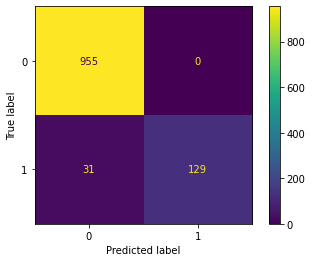

In [359]:
plot_confusion_matrix(naive_bayes_classifer_3, x_test_3, y_test_3);

In [360]:
accuracy_score(y_pred3, y_test_3)

0.9721973094170404

### Precsion and recall

In [366]:
average_precision_1 = average_precision_score(y_test, y_pred)
average_precision_2 = average_precision_score(y_test2, y_pred2)
average_precision_3 = average_precision_score(y_test_3, y_pred3)

In [368]:
print(average_precision_1);print()
print(average_precision_2);print()
print(average_precision_3)

0.8568957594639691

0.8877399587554671

0.8340526905829596


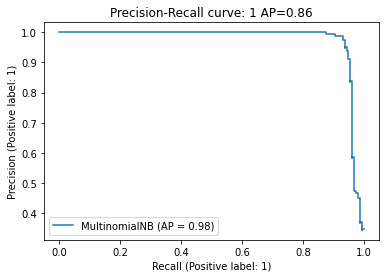

In [388]:
disp = plot_precision_recall_curve(naive_bayes_classifer, x_test, y_test)
disp.ax_.set_title('Precision-Recall curve: 1 '
                   'AP={0:0.2f}'.format(average_precision_1));

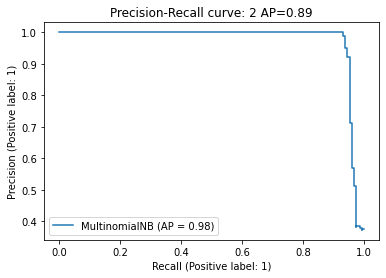

In [386]:
disp = plot_precision_recall_curve(naive_bayes_classifer_2, x_test_2, y_test_2)

disp.ax_.set_title('Precision-Recall curve: 2 '
                   'AP={0:0.2f}'.format(average_precision_2));

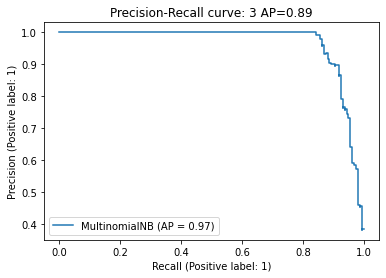

In [389]:
disp = plot_precision_recall_curve(naive_bayes_classifer_3, x_test_3, y_test_3)

disp.ax_.set_title('Precision-Recall curve: 3 '
                   'AP={0:0.2f}'.format(average_precision_2));
